In [22]:
# imports
import pandas as pd                              # it's pandas
import Constants as c                           # constants
import Functions as f                           # plotting functions
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as po
import pickle
from math import radians
from scipy.stats import gaussian_kde, weibull_min
from random import randint
from scipy.optimize import curve_fit
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo


In [23]:
# Import dataframe from "out" folder
with open('../out/TREAD_out.pkl', 'rb') as file:
    df, trips_list, name_of_route = pickle.load(file)
# pick one random trip to fiddle with it
#sample_trip = trips_list[73]
sample_trip = trips_list[1]
display(f"There are in total {df['trip_id'].max() + 1} separate trips and {df['Route'].unique().shape[0]} total routes")

'There are in total 45384 separate trips and 898 total routes'

In [24]:
# some info about the dataframe
sample_trip.reset_index(inplace=True, drop=True)
# the above instruction sometimes adds a new column called 'index', which is subsequently removed
if 'index' in sample_trip.columns:
    print("Column \"Index\" removed")
    sample_trip.drop(['index'], axis=1, inplace=True)
display(sample_trip.head(3))
#display(df)
# current columns (aka features) of the dataset
print(df.columns)
display(df.info())

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,...,Draft,IsClassA,Avg_Speed,EstimatedStatus,IsInWP,IsInSignificantWP,Route,IsInRoute,group,trip_id
0,303174000,2019-02-20 18:55:58,21.3100,-157.8744,7.5,124.9,511.0,GAIL ANN,30,99,...,NaN,False,3.98,sailing,WP_152,<NA>,WP_152 - WP_120,True,1,1316
1,303174000,2019-02-20 18:56:59,21.3086,-157.8727,7.6,135.1,511.0,GAIL ANN,30,99,...,NaN,False,7.50,sailing,WP_152,<NA>,WP_152 - WP_120,True,0,1316
2,303174000,2019-02-20 18:59:33,21.3042,-157.8693,7.6,149.9,511.0,GAIL ANN,30,99,...,NaN,False,7.62,sailing,WP_152,<NA>,WP_152 - WP_120,True,0,1316


Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
       'VesselName', 'VesselType', 'Status', 'Length', 'Width', 'Draft',
       'IsClassA', 'Avg_Speed', 'EstimatedStatus', 'IsInWP',
       'IsInSignificantWP', 'Route', 'IsInRoute', 'group', 'trip_id'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 5460702 entries, 0 to 2
Data columns (total 22 columns):
 #   Column             Dtype        
---  ------             -----        
 0   MMSI               int32        
 1   BaseDateTime       datetime64[s]
 2   LAT                float64      
 3   LON                float64      
 4   SOG                float64      
 5   COG                float64      
 6   Heading            float64      
 7   VesselName         string       
 8   VesselType         int16        
 9   Status             int8         
 10  Length             int16        
 11  Width              int16        
 12  Draft              float32      
 13  IsClassA           bool   

None

#### General Approach
1. Normalization (some features have different scales) (to be decided, probably not)
2. Features selection
3. Algorithm

In [25]:
# check which columns contain any null values
df.isnull().sum()

MMSI                       0
BaseDateTime               0
LAT                        0
LON                        0
SOG                        0
COG                        0
Heading                    0
VesselName            456248
VesselType                 0
Status                     0
Length                     0
Width                      0
Draft                3618047
IsClassA                   0
Avg_Speed                  0
EstimatedStatus            0
IsInWP               1278778
IsInSignificantWP    1734711
Route                      0
IsInRoute                  0
group                      0
trip_id                    0
dtype: int64

In [26]:
# all the trips of the chosen route are separated in a list
# create a single dataframe with all of them together
#myDF = pd.concat(trips_list, ignore_index=True, axis=0)
myDF = df[df['Route'] == 'WP_120' + ' - ' + 'WP_152']
myDF = pd.concat([myDF, df[df['Route'] == 'WP_61' + ' - ' + 'WP_96']], axis=0)
#myDF = pd.concat([myDF, df[df['Route'] == 'WP_96' + ' - ' + 'WP_61']], axis=0)


,trip_id,count
0,8418,595
1,16702,251
2,17214,242
3,16775,239
4,3784,228
...,...,...
446,30246,20
447,30321,20
448,29962,14
449,29894,13


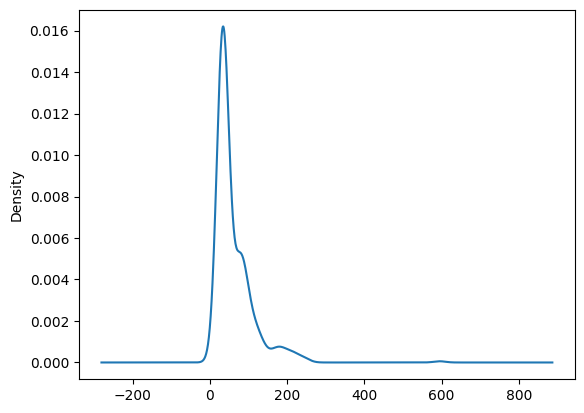

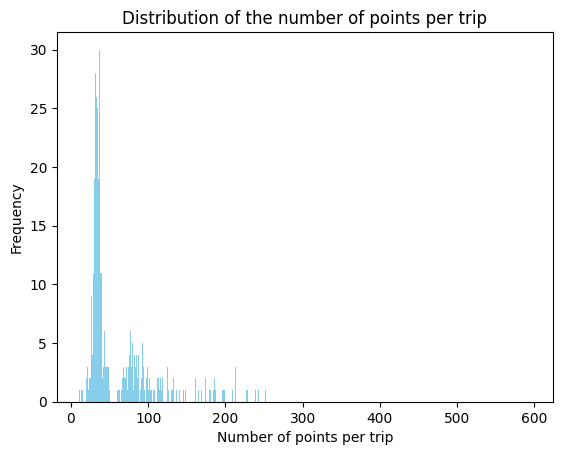

In [27]:
# for each trip_id, extract how many points where generated
points_per_trip = myDF['trip_id'].value_counts().reset_index(name='count')

display(points_per_trip)

# plot the kde approximation of the distribution of the amount of points per trip
points_per_trip["count"].plot(kind="kde")
# plot a more precise histogram of the same distribution
plt.figure()
plt.hist(points_per_trip['count'], 
         bins=range(min(points_per_trip['count']), max(points_per_trip['count']) + 1, 1), # from, to, step
         color='skyblue')
plt.xlabel('Number of points per trip')
plt.ylabel('Frequency')
plt.title('Distribution of the number of points per trip')
plt.show()

In [28]:
# Calculate x and y components of speed starting from known values of SOG and COG
# System of equations (as written in the paper): 1) SOG^2 = Vx^2 + Vy^2, 2) COG = arctan((Vy)/(Vx))
# For equation #2, there is an issue as arctan is hard to invert. So instead of using this system of equations, we can use another one:
# New system of equations: 1) Vx = SOG * cos(COG), 2) Vy = SOG * sin(COG)

# First step: convert true north COG angles into standard arithmetic angles.
# Formula: X = (450 - COG) mod 360 
# https://community.safe.com/general-10/how-to-convert-arithmetic-angles-to-geographic-angles-18164

myDF['A_COG'] = (450 - myDF['COG']) % 360
display(myDF['A_COG'].head(3))
# convert the arithmetic angles in radians
myDF['A_COG'] = myDF['A_COG'].apply(radians)
display(myDF['A_COG'].head(3))
# calculate Vx and Vy
myDF['V_x'] = myDF['SOG'] * np.cos(myDF['A_COG'])
myDF['V_y'] = myDF['SOG'] * np.sin(myDF['A_COG'])
display(myDF[['V_x', 'V_y']].head(3))

# optional: compare with points on map:
#plot = f.route_arrows_plot(inputDF=myDF.head(3).copy(), color_criteria='Avg_Speed', scale_factor=0.0001)
#po.plot(plot, auto_open=True)

173    237.5
174    226.9
175    236.1
Name: A_COG, dtype: float64

173    4.145157
174    3.960152
175    4.120722
Name: A_COG, dtype: float64

,V_x,V_y
173,-3.277528,-5.144688
174,-10.385761,-11.098467
175,-8.533500,-12.699188


In [29]:
# Divide the dataset in train and test

# Select supposedly good trips to use as "normal" behaviour -> train dataset
points_per_trip.sort_values(by="count", ascending=True, inplace=True)

# Supposedly Good Trips (save the IDs)
train_ids = pd.Series(name="trip_id") # new empty Series
# coefficient used to separate train dataset from test dataset
GT_COEFF = 1 # G.T. = "Good Trips"
# Fill the Series with the "trip_id" of the first (GT_COEFF)% of trips (ordered from shortest to longest)
train_ids = points_per_trip.iloc[0:int(len(points_per_trip) * GT_COEFF), 0]
test_ids = set(points_per_trip["trip_id"]).difference(train_ids)

try: # quick check
    assert len(train_ids) + len(test_ids) == len(points_per_trip)
except AssertionError:
    print(f"Error: {len(train_ids)} + {len(test_ids)} should be equal to {len(points_per_trip)}. Values not matching")

# Create a new DF with the full data of the selected trips
train_DF = myDF[myDF['trip_id'].isin(train_ids)]
test_DF = myDF[myDF['trip_id'].isin(test_ids)]

#final_DF = 

# quick check: from a groupby (on trip_id) of train_df I expect the number of rows to be equal to the len of train_ids
test_delete = train_DF.groupby(by="trip_id")
try:
    assert len(train_ids) == len(test_delete), "Should be the same length"
except AssertionError:
    print(f"Error: {len(train_ids)} should be equal to {len(test_delete)}. Values not matching")
del test_delete

plot = f.route_arrows_plot(inputDF=train_DF, color_criteria='Avg_Speed', scale_factor=0.0001, title=f'Train dataset (coeff: {GT_COEFF}) of Route {train_DF.iloc[0, train_DF.columns.get_loc("Route")]}')
po.plot(plot, auto_open=True, filename='../plot/selected_trips.html')

plot = f.route_arrows_plot(inputDF=test_DF, color_criteria='Avg_Speed', scale_factor=0.0001, title=f'Test dataset (coeff: {round(1-GT_COEFF, 1)}) of Route {train_DF.iloc[0, train_DF.columns.get_loc("Route")]}')
po.plot(plot, auto_open=True, filename='../plot/non_selected_trips.html')

'../plot/non_selected_trips.html'

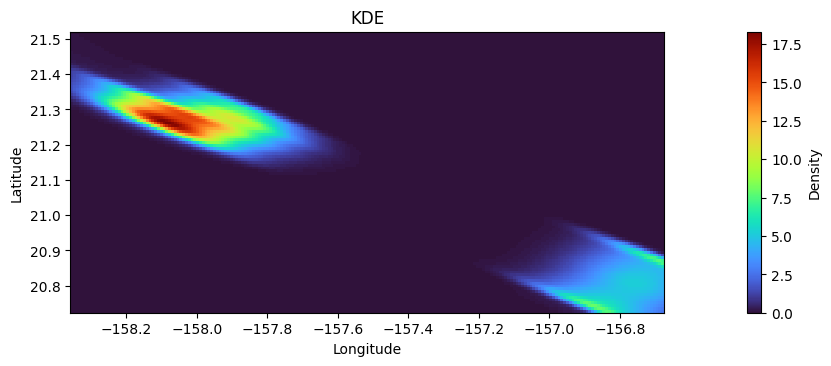

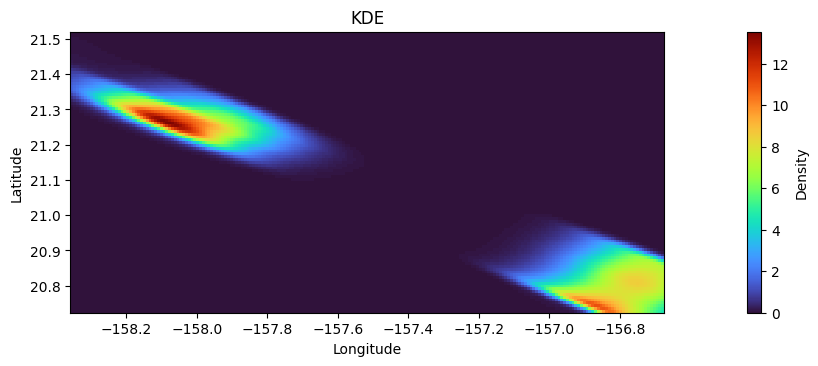

In [30]:
# Extract grid ranges
lon_min, lon_max = train_DF['LON'].min(), train_DF['LON'].max()
lat_min, lat_max = train_DF['LAT'].min(), train_DF['LAT'].max()

# keep same aspect ration
lon_range = lon_max - lon_min
lat_range = lat_max - lat_min
aspect_ratio = lon_range / lat_range

n_points = 100 
lon_points = int(n_points * aspect_ratio)
lat_points = n_points
    
# Create the actual grid
lon_grid = np.linspace(lon_min, lon_max, lon_points) # create equally spaced points from lon_min to lon_max
lat_grid = np.linspace(lat_min, lat_max, lat_points)
LON, LAT = np.meshgrid(lon_grid, lat_grid) # creates rectangular grid of points out of lon, lat values

# Calculate KDE using LAT, LON values
positions = np.vstack([LON.ravel(), LAT.ravel()])
values = np.vstack([train_DF['LON'], train_DF['LAT']])
kernel_geo = gaussian_kde(values)
Z_geo = np.reshape(kernel_geo(positions), LON.shape)

# Calculate KDE using V_x, V_y values
# Geographical coordinates are weighted using the magnitude of the vector V
values_v = np.vstack([train_DF['LON'], train_DF['LAT']])
kernel_v = gaussian_kde(values_v, weights=train_DF['SOG'])
Z_v = np.reshape(kernel_v(positions), LON.shape)

# Calculate size of the plot in order to keep the aspect ratio
base_size = 8
fig_width = base_size * aspect_ratio if aspect_ratio > 1 else base_size
fig_height = base_size / aspect_ratio if aspect_ratio > 1 else base_size
    
# Plot in separate figures
# KDE of LAT,LON values
fig = f.plot_kde(LON, LAT, Z_geo, fig_width, fig_height)

# plot KDE of speed vectors
fig = f.plot_kde(LON, LAT, Z_v, fig_width, fig_height)

plt.show()

In [31]:
# check that the integral sum is equal to one (since KDE returns a probability density)
# Calculate the area of a cell of the grid
d_lon = lon_grid[9] - lon_grid[8] # difference between two consecutive lon values
d_lat = lat_grid[9] - lat_grid[8] # difference between two consecutive lat values
dA = d_lon * d_lat # differential area dA (used to do the integration)

# Calculate integral sum for both KDEs by rows and by columns
integral_geo = np.sum(np.sum(Z_geo, axis=1), axis=0) * dA # this works because the grid is equally spaced
integral_v = np.sum(np.sum(Z_v, axis=1), axis=0) * dA # with an irregular grid "np.trapz()" should be used

# This two values below need to be very close to one, otherwise there is something wrong with the KDE
print(f"Geo KDE integral sum: {integral_geo}")
print(f"V KDE integral sum: {integral_v}")

Geo KDE integral sum: 0.884433757347467
V KDE integral sum: 0.8282634088945008


In [32]:
train_DF.reset_index(inplace=True)
display(train_DF.head(3))
#train_DF.set_index(['MMSI', 'BaseDateTime'], inplace=True)
#display(train_DF.head(3))

,index,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,...,EstimatedStatus,IsInWP,IsInSignificantWP,Route,IsInRoute,group,trip_id,A_COG,V_x,V_y
0,173,338091016,2019-01-06 01:33:55,21.3257,-158.1210,6.1,212.5,511.0,TERRIE O,37,...,sailing,WP_120,<NA>,WP_120 - WP_152,True,1,2260,4.145157,-3.277528,-5.144688
1,174,338091016,2019-01-06 01:37:25,21.3198,-158.1248,15.2,223.1,511.0,TERRIE O,37,...,sailing,WP_120,<NA>,WP_120 - WP_152,True,0,2260,3.960152,-10.385761,-11.098467
2,175,338091016,2019-01-06 01:38:26,21.3166,-158.1280,15.3,213.9,511.0,TERRIE O,37,...,sailing,WP_120,<NA>,WP_120 - WP_152,True,0,2260,4.120722,-8.533500,-12.699188


In [33]:
# Calculate product between Spatial KDE and Speed KDE (see equation 8 page 2236)
Z_product = Z_geo * Z_v

try:
    assert (Z_product.shape == Z_geo.shape) and (Z_product.shape == Z_v.shape)
    assert Z_product[0][0] == Z_geo[0][0] * Z_v[0][0]
except AssertionError:
    print("The final matrix should have the same shape of the starting matrices")

DISTANCE_PARAMETER_METERS = 500

train_DF = train_DF.copy() # this is necessary in order to remove an annoying warning (SettingWithCopyWarning)

lons = train_DF['LON'].values
lats = train_DF['LAT'].values

# For each point, save a boolean mask with True values for points that are within the distance threshold
train_DF['Points_Mask'] = pd.Series(dtype=object)

for i in range(len(train_DF)):
    lat1 = np.full_like(lats, train_DF.iloc[i, train_DF.columns.get_loc('LAT')])
    lon1 = np.full_like(lons, train_DF.iloc[i, train_DF.columns.get_loc('LON')])
    distances = f.great_circle_distance_vectorized(lon_left=lon1,
                                                   lat_left=lat1,
                                                   lon_right=lons,
                                                   lat_right=lats)
    boolean_mask = (distances < DISTANCE_PARAMETER_METERS)
    train_DF.at[i,'Points_Mask'] = boolean_mask

# test with random points

random_row_number = randint(0, len(train_DF))
chosen_mask = train_DF.loc[random_row_number, 'Points_Mask'].copy()

f.route_plot(inputDF=train_DF, color_criteria=chosen_mask, title='Distance test plot', filename='regions_test_plot.html')


In [34]:
# Extract desity values of each point
# Two different approaches: reverse of KDE or linear interpolation

train_DF['Density'] = pd.Series(dtype=pd.Float64Dtype())

# Approach 1: parse LON,LAT values to the density kernels used before in order to get the density values in return

density_vals_geo = kernel_geo(np.array([train_DF['LON'], train_DF['LAT']]))
density_vals_V = kernel_v(np.array([train_DF['LON'], train_DF['LAT']]))
train_DF['Density'] = density_vals_geo * density_vals_V

# Approach 2: interpolate from already know density values associated to the grid used to calculate the KDE
# This works decently only if the grid has many points
from scipy.interpolate import RegularGridInterpolator

intp_fun = RegularGridInterpolator((lon_grid, lat_grid), Z_product.T)
interpolated_density_vals = intp_fun(np.column_stack((train_DF['LON'], train_DF['LAT'])))

# Check the correlation between the values calculated by reversing the KDE and the interpolated ones
display(train_DF['Density'].corr(pd.Series(interpolated_density_vals)))

# Plot the result on a map
f.route_plot(inputDF=train_DF, title='Show KDE pdf of each point', color_criteria=train_DF['Density'], filename='KDE_pdf.html')


0.9996700643796734

In [35]:
# Calculate production (produttoria) of values

train_DF['Density_prod'] = pd.Series(dtype=pd.Float64Dtype())
train_DF['Log_Density_prod'] = pd.Series(dtype=pd.Float64Dtype())

# test to find the row with most True values in 'Points_Mask'
train_DF['Count_Trues'] = train_DF['Points_Mask'].apply(lambda x: sum(x))
idx_max_true = train_DF['Count_Trues'].idxmax()
found_row = train_DF.loc[idx_max_true]
display(idx_max_true)
display(found_row)


# array for saving density products
density_products = np.ones(len(train_DF))
log_density_products = np.zeros(len(train_DF))

# iterate along the rows of the dataframe
for i in range(len(train_DF)):
    mask = train_DF.iloc[i]['Points_Mask']
    density_products[i] = np.prod(train_DF.loc[mask, 'Density'])
    log_density_products[i] = np.sum(np.log(train_DF.loc[mask, 'Density']))

# Save the resulting array of arrays into a column of the dataframe
train_DF['Density_prod'] = density_products
train_DF['Log_Density_prod'] = log_density_products

found_row = train_DF.loc[idx_max_true]
display(found_row)


19079

index                                                             3513
MMSI                                                         367745320
BaseDateTime                                       2019-01-12 21:20:18
LAT                                                             20.869
LON                                                          -156.6822
SOG                                                                9.3
COG                                                               43.7
Heading                                                           45.0
VesselName                                             EXPEDITIONS SIX
VesselType                                                          60
Status                                                              15
Length                                                               0
Width                                                                0
Draft                                                              NaN
IsClas

/home/accazeta/.local/lib/python3.10/site-packages/numpy/core/_methods.py:53: RuntimeWarning:

overflow encountered in reduce



index                                                             3513
MMSI                                                         367745320
BaseDateTime                                       2019-01-12 21:20:18
LAT                                                             20.869
LON                                                          -156.6822
SOG                                                                9.3
COG                                                               43.7
Heading                                                           45.0
VesselName                                             EXPEDITIONS SIX
VesselType                                                          60
Status                                                              15
Length                                                               0
Width                                                                0
Draft                                                              NaN
IsClas

In [36]:
# Calculate density products
log_density_products = np.zeros(len(train_DF))

# for each row of the dataframe
for i in range(len(train_DF)):
    mask = train_DF.iloc[i]['Points_Mask']
    # extract values that need to be multiplied
    filtered_densities = train_DF.loc[mask, 'Density']
    # calculate the sum of logaritms instead of the production
    log_density_products[i] = round(np.sum(np.log(filtered_densities)), 2)
    # inverse operation to go back to the original values:
    # density_products[i] = np.exp(log_density_products[i])

# Save the result inside the dataframe
train_DF['Log_Density_prod'] = log_density_products

# Normalization to compare relative values
# The scale goes from min_log to max_log
min_log = train_DF['Log_Density_prod'].min()
max_log = train_DF['Log_Density_prod'].max()
train_DF['Normalized_Log_Density'] = (train_DF['Log_Density_prod'] - min_log) / (max_log - min_log)

# Describe the resulting dataframe columns
print("Log density values:")
print(train_DF['Log_Density_prod'].describe())
print("Normalized Values:")
print(train_DF['Normalized_Log_Density'].describe())

f.route_plot(inputDF=train_DF, title='Production result before normalization', color_criteria=train_DF['Log_Density_prod'], filename='log_KDE.html')
f.route_plot(inputDF=train_DF, title='Production result after normaliztion', color_criteria=train_DF['Normalized_Log_Density'], filename='normalized_log_KDE.html')

Log density values:
count    27574.000000
mean       843.963202
std        827.744990
min        -36.760000
25%        360.670000
50%        550.065000
75%       1039.845000
max       4121.000000
Name: Log_Density_prod, dtype: float64
Normalized Values:
count    27574.000000
mean         0.211826
std          0.199084
min          0.000000
25%          0.095588
50%          0.141140
75%          0.258939
max          1.000000
Name: Normalized_Log_Density, dtype: float64


#### Prediction and stuff using Weibull

Dataset size: 27574 rows
Number of unique ships (MMSI): 43
Number of unique trips: 451
Time range: 2019-01-01 19:01:35 to 2019-03-31 21:18:53

Trip statistics:
Average points per trip: 61.1
Min points per trip: 11, Max points per trip: 595

Calculating trip durations...
Check if everything works fine:
  Trip 2260: start=2019-01-06 01:33:55, end=2019-01-06 03:05:55, duration=5520.0 seconds
Check if everything works fine:
  Trip 2262: start=2019-03-21 16:12:05, end=2019-03-21 19:21:08, duration=11343.0 seconds
Check if everything works fine:
  Trip 2404: start=2019-01-02 19:53:11, end=2019-01-02 22:10:08, duration=8217.0 seconds

Trip duration statistics seconds (minutes):
  Minimum: 2422.0 (40.4)
  Maximum: 57440.0 (957.3)
  Median: 3002.0 (50.0)


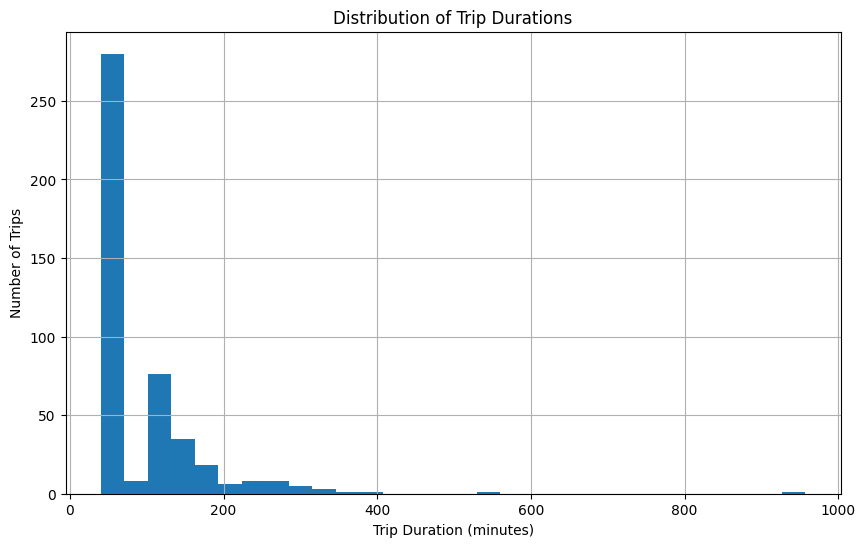

In [37]:
# Print DataFrame summary
print(f"Dataset size: {len(train_DF)} rows")
print(f"Number of unique ships (MMSI): {train_DF['MMSI'].nunique()}")
print(f"Number of unique trips: {train_DF['trip_id'].nunique()}")
print(f"Time range: {train_DF['BaseDateTime'].min()} to {train_DF['BaseDateTime'].max()}")

# Create a summary of trips
trip_counts = train_DF.groupby('trip_id').size()
print(f"\nTrip statistics:")
print(f"Average points per trip: {trip_counts.mean():.1f}")
print(f"Min points per trip: {trip_counts.min()}, Max points per trip: {trip_counts.max()}")

# Calculate trip durations based on actual timestamps
trip_durations = {}
all_trip_ids = trip_counts.index

print("\nCalculating trip durations...")
for trip_id in all_trip_ids:
    trip_data = train_DF[train_DF['trip_id'] == trip_id]
    if len(trip_data) >= c.SHORT_TRIP_THRESHOLD:
        # Get the first and last timestamp for this trip
        start_time = trip_data['BaseDateTime'].min()
        end_time = trip_data['BaseDateTime'].max()
        # Calculate duration in seconds
        duration = (end_time - start_time).total_seconds()
        trip_durations[trip_id] = duration # save the duration to a dictionary
        # Debug output for the first few trips
        if len(trip_durations) <= 3:
            print("Check if everything works fine:")
            print(f"  Trip {trip_id}: start={start_time}, end={end_time}, duration={duration:.1f} seconds")

# Calculate statistics on trip durations
durations = np.array(list(trip_durations.values())) # convert dict values to ndarray to easily calculate statistics
min_duration = np.min(durations)
max_duration = np.max(durations)
median_duration = np.median(durations)

print(f"\nTrip duration statistics seconds (minutes):")
print(f"  Minimum: {min_duration:.1f} ({min_duration/60:.1f})")
print(f"  Maximum: {max_duration:.1f} ({max_duration/60:.1f})")
print(f"  Median: {median_duration:.1f} ({median_duration/60:.1f})")

# Plot trip duration distribution
plt.figure(figsize=(10, 6))
plt.hist(durations/60, bins=30)
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Number of Trips')
plt.title('Distribution of Trip Durations')
plt.grid(True)
plt.show()

Calculate time lags (adaptively) and distance statistics for each time lag 


Adaptive time lags (seconds):
  Median lag: 360.00
  121 sec (2.0 min)
  169 sec (2.8 min)
  216 sec (3.6 min)
  264 sec (4.4 min)
  312 sec (5.2 min)
  360 sec (6.0 min)
  408 sec (6.8 min)
  456 sec (7.6 min)
  504 sec (8.4 min)
  552 sec (9.2 min)
  600 sec (10.0 min)


Distance statistics for each time lag:
For lag 121s: 25632 points, average distance: 718.11 m
For lag 169s: 25800 points, average distance: 987.23 m
For lag 216s: 25623 points, average distance: 1254.75 m
For lag 264s: 25668 points, average distance: 1556.21 m
For lag 312s: 25557 points, average distance: 1839.01 m
For lag 360s: 25379 points, average distance: 2121.54 m
For lag 408s: 25053 points, average distance: 2400.70 m
For lag 456s: 24861 points, average distance: 2684.06 m
For lag 504s: 24653 points, average distance: 2955.22 m
For lag 552s: 24413 points, average distance: 3222.16 m
For lag 600s: 24194 points, average distance: 3495.05 m


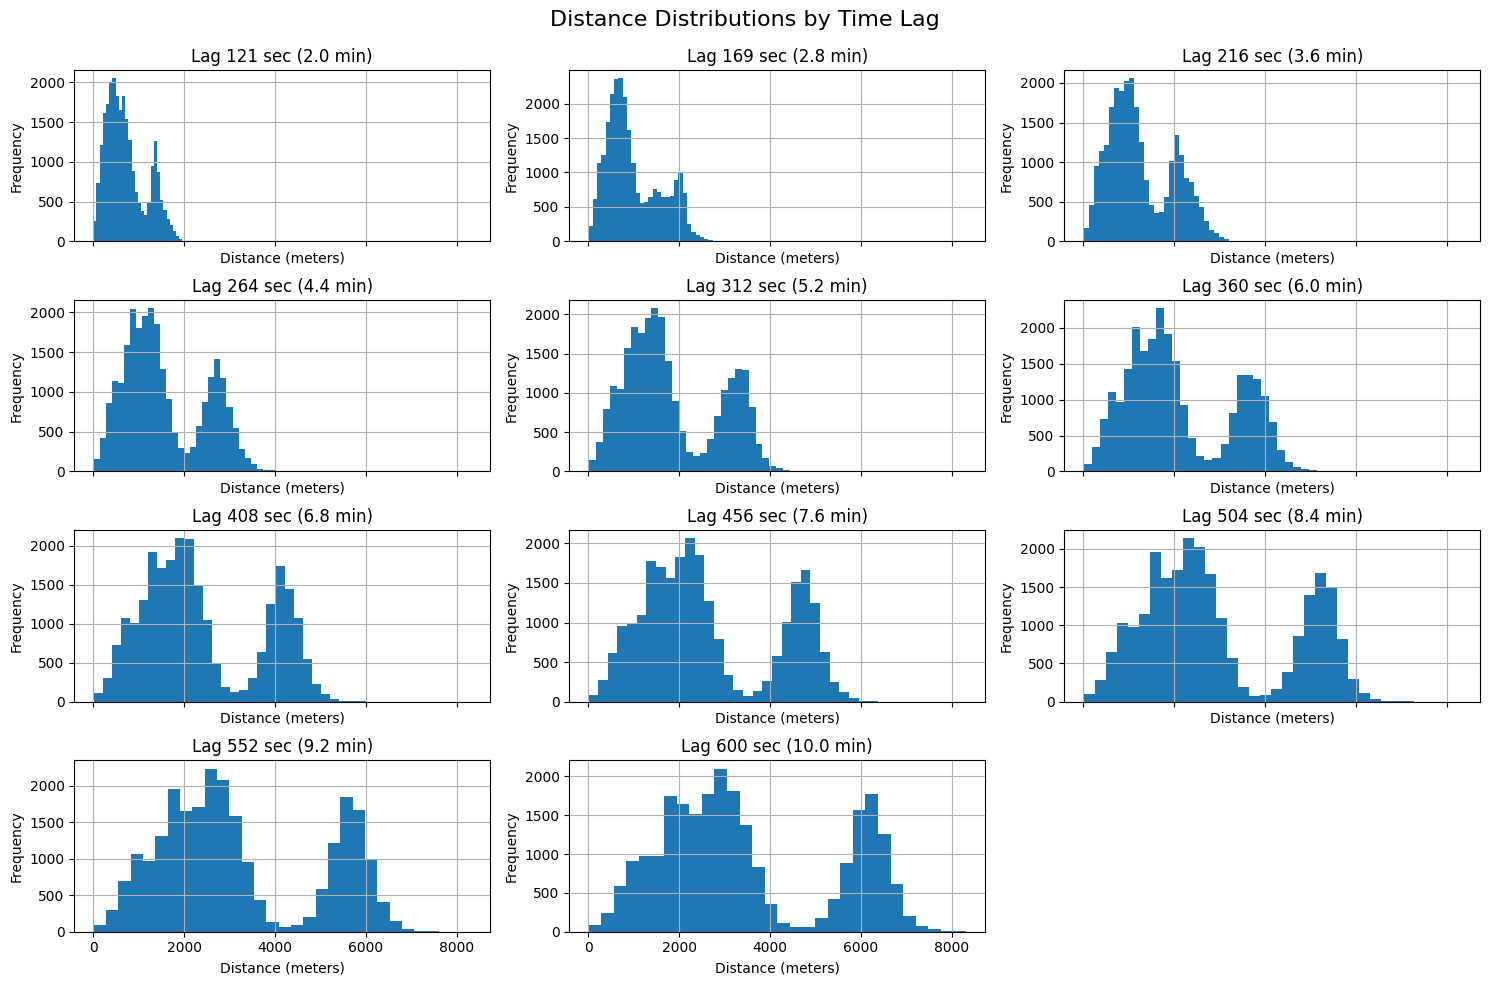

In [38]:
# Determine adaptive time lags based on dataset
# For short trips, use smaller time lags
#----------CHECK-----------------
# The minimum should be the AIS refresh rate in the area?
min_lag = max(30, min_duration / 20)  # At least 30 seconds or 1/20 of shortest trip
max_lag = min(median_duration / 5, 3600)  # At most 1/5 of median trip or 1 hour


# Create time lags at even intervals between min and max lag
num_lags = 11  # In the paper Pallotta goes from 5 minutes to 60 minutes with 5 minutes steps: 11 lags in total
time_lags_seconds = np.linspace(min_lag, max_lag, num_lags).astype(int) # 11 evenly spaced values between min_lag and max_lag
time_lags_seconds = np.unique(time_lags_seconds)  # Ensure all values are unique (for very short trips)
median_lag = np.median(time_lags_seconds)

print(f"\nAdaptive time lags (seconds):")
print(f'  Median lag: {median_lag:.2f}')
for lag in time_lags_seconds:
    print(f"  {lag} sec ({lag/60:.1f} min)")

# Prepare data structures to collect distance data for different time intervals
distances_by_lag = {lag: [] for lag in time_lags_seconds} # for each lag create a pair where the lag is the key and the value is an empty list

print(f"\nCollecting distance data from all {len(all_trip_ids)} trips...")

# for each trip
for trip_id in all_trip_ids:
    # collect all points and sort them
    trip_data = train_DF[train_DF['trip_id'] == trip_id].sort_values('BaseDateTime')
    # discard short trips
    if len(trip_data) < c.SHORT_TRIP_THRESHOLD:
        continue
    
    # For each point in the trip (except the first one, with index = 0)
    for i in range(1, len(trip_data)):
        # get current timestamp and GPS coordinates
        current_time = trip_data.iloc[i]['BaseDateTime']
        current_pos = [trip_data.iloc[i]['LON'], trip_data.iloc[i]['LAT']]
        
        # For each time lag created above
        for lag in time_lags_seconds:
            # Look for a point that is approximately 'lag' seconds before
            desired_time = current_time - pd.Timedelta(seconds=lag)
            
            # Skip if the desired time is before the start of the trip
            if desired_time < trip_data['BaseDateTime'].min():
                continue
            
            # Find the index of the point with timestamp closest to desired_time
            time_diffs = abs((trip_data['BaseDateTime'] - desired_time).dt.total_seconds())
            prev_idx = time_diffs.idxmin() # returns the index of the row with the minumum value
            # Calculate the actual time difference with the found point
            actual_time_diff = (current_time - trip_data.loc[prev_idx, 'BaseDateTime']).total_seconds()
            
            # Use the found point only if the time difference is close enough to the desired interval
            # For very short time lags, we need to be more tolerant
            if lag <= min_lag * 1.5:
                tolerance = 0.5 # 50%
            elif lag <= median_lag:
                tolerance = 0.4 # 40%
            else:
                tolerance = 0.3 # 30%
            # if the found point is too far away in time,
            if abs(actual_time_diff - lag) > lag * tolerance:
                continue # go back to the beginning of the for loop and do not use it
            
            # Save x, y, V_x, V_y values to build 'vectors' (eq. 2 page 2234)
            prev_pos = [trip_data.loc[prev_idx, 'LON'], trip_data.loc[prev_idx, 'LAT']]
            # Use the V_x and V_y columns for velocity components (equation 2, page 2234)
            prev_vel = [trip_data.loc[prev_idx, 'V_x'], trip_data.loc[prev_idx, 'V_y']]
            
            # Predict the position using Track Predictor (Algorithm 4, page 2237)
            pred_pos = [
                prev_pos[0] + prev_vel[0] * actual_time_diff / 3600,  # speed is expected to be in nautical knots
                prev_pos[1] + prev_vel[1] * actual_time_diff / 3600   # but no checks are done in that direction  
            ]
            
            # Calculate the distance between the predicted and actual position (Δp in equation 10)
            delta_p = np.sqrt((current_pos[0] - pred_pos[0])**2 + (current_pos[1] - pred_pos[1])**2)
            #delta_p = f.great_circle_distance_vectorized(
            #                                            lon_left=current_pos[0], lat_left=current_pos[1],
            #                                            lon_right=pred_pos[0], lat_right=pred_pos[1]
            #                                            )
            #delta_p = delta_p / c.METERS_EVERY_NM # convert from meters to nautical miles
            
            # Convert the distance to meters (assuming LON/LAT are in degrees)
            delta_p_meters = delta_p * c.METERS_EVERY_NM  # 1 nautical mile = 1852 meters
            
            distances_by_lag[lag].append(delta_p_meters) # save the distances in the dict

# Convert lists to numpy arrays for processing
distances_arrays = [np.array(distances_by_lag[lag]) for lag in time_lags_seconds] # time_lags_seconds: list of unique lags

# Print statistics on collected distances
print("\nDistance statistics for each time lag:")
for i, lag in enumerate(time_lags_seconds):
    dist_array = distances_arrays[i]
    if len(dist_array) > 0:
        print(f"For lag {lag}s: {len(dist_array)} points, average distance: {np.mean(dist_array):.2f} m")
    else:
        print(f"For lag {lag}s: No valid points found")

# Plot distance distributions for each time lag (grouped in a single figure)
# Automatically detect number of rows and columns for subplots
valid_arrays = [i for i, arr in enumerate(distances_arrays) if len(arr) > 0] # do not plot arrys with 0 elements
n_valid = len(valid_arrays)

if n_valid > 0:
    n_cols = min(3, n_valid)
    n_rows = (n_valid + n_cols - 1) // n_cols # floor division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10), sharex=True)
    if n_rows * n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for i, idx in enumerate(valid_arrays):
        lag = time_lags_seconds[idx]
        if i < len(axes):
            axes[i].hist(distances_arrays[idx], bins=30)
            axes[i].set_title(f'Lag {lag} sec ({lag/60:.1f} min)')
            axes[i].set_xlabel('Distance (meters)')
            axes[i].set_ylabel('Frequency')
            axes[i].grid(True)
    
    # Hide unused subplots
    for i in range(len(valid_arrays), len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.suptitle('Distance Distributions by Time Lag', fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()
else:
    print("No valid data to be plotted")

Estimate Weibull parameters

Lag 121 sec: Estimated shape=1.7143, scale=806.8158
Lag 169 sec: Estimated shape=1.7475, scale=1111.5301
Lag 216 sec: Estimated shape=1.8744, scale=1415.9738
Lag 264 sec: Estimated shape=1.8734, scale=1756.5003
Lag 312 sec: Estimated shape=1.8793, scale=2076.3325
Lag 360 sec: Estimated shape=1.9132, scale=2396.5041
Lag 408 sec: Estimated shape=1.9348, scale=2712.4954
Lag 456 sec: Estimated shape=1.9322, scale=3033.2131
Lag 504 sec: Estimated shape=1.9268, scale=3339.2119
Lag 552 sec: Estimated shape=1.9427, scale=3641.8414
Lag 600 sec: Estimated shape=1.9445, scale=3950.1761


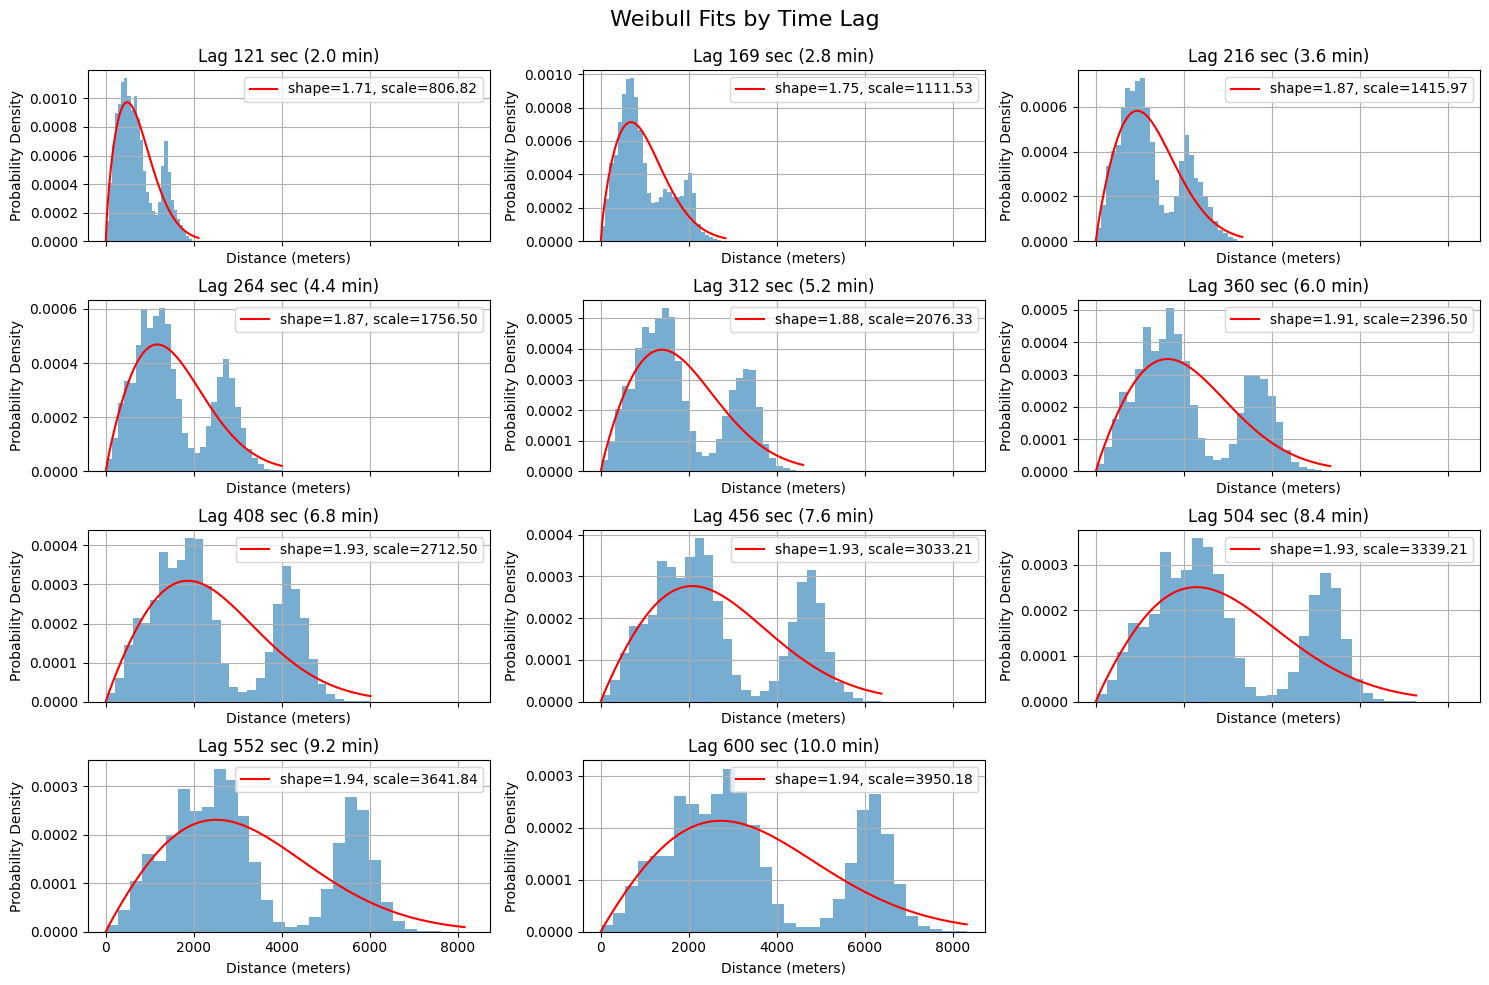


Estimated parameter m: 6.619841610474961
Average shape parameter (β): 1.8802746230486045


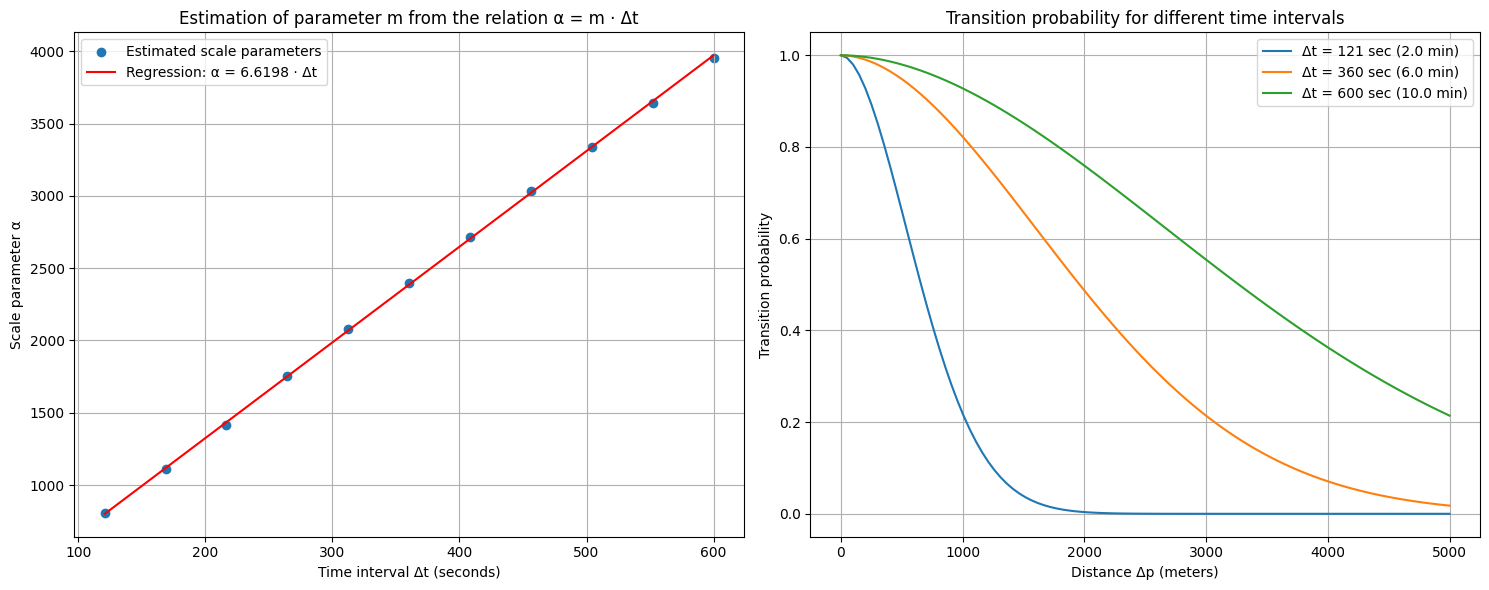


Calculating state sequence probabilities for all trips...
State sequence probability statistics:
  Number of trips processed: 451
  Mean: -0.0007
  Min: -0.0013
  Max: -0.0001
  Std Dev: 0.0004

Calculating combined probabilities for all trips...
Combined probability statistics:
  Number of trips: 451
  Mean: 925.4697
  Min: 15.4074
  Max: 1940.9017
  Std Dev: 185.9034


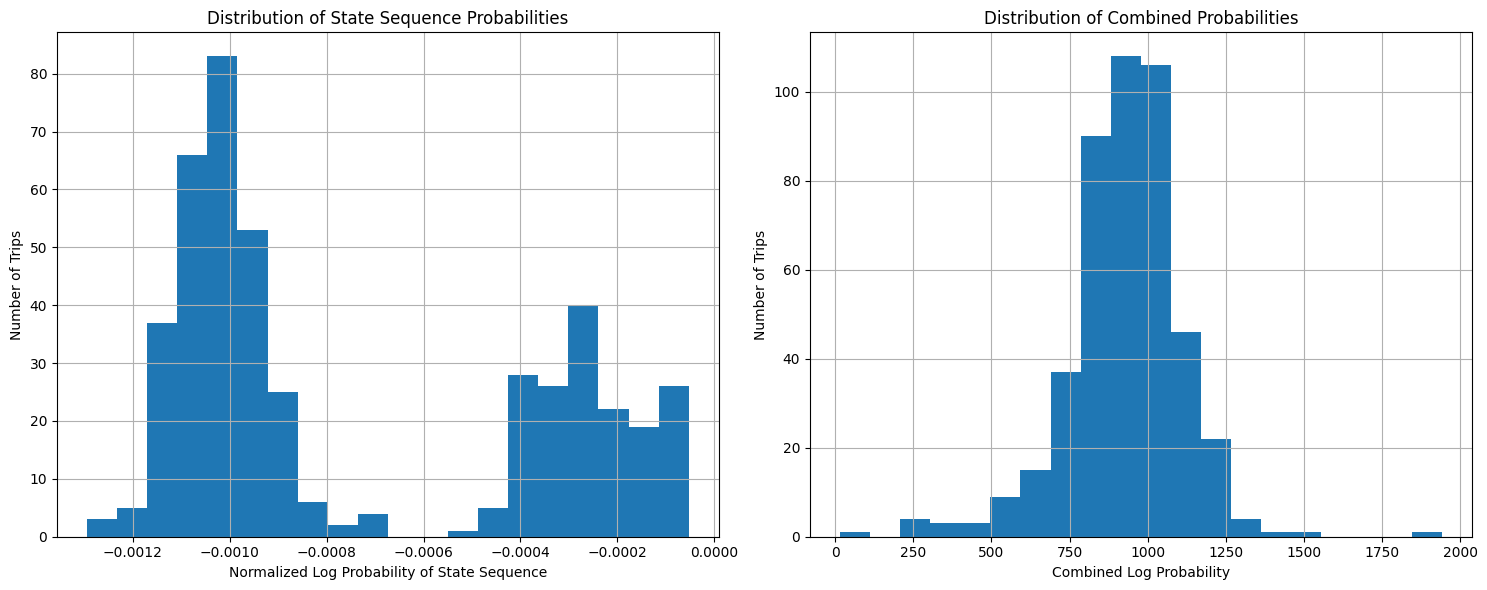

[(1940.9016956469193, 29962),
 (1542.025543181495, 29894),
 (1455.6972239541162, 29634),
 (1329.9853419657325, 30232),
 (1329.8327917292315, 30221),
 (1315.716468742723, 30136),
 (1314.103177498149, 30265),
 (1264.3745077103483, 29604),
 (1260.9968749055172, 30246),
 (1255.8368766813462, 24596),
 (1255.4952326782427, 30162),
 (1238.7865464644083, 29940),
 (1229.7335707236964, 30027),
 (1225.2341371176944, 29872),
 (1220.7072604919902, 29628),
 (1219.2259460728221, 29544),
 (1214.3550208805464, 29697),
 (1214.2164799723828, 30226),
 (1205.173299098135, 30217),
 (1197.5714231153381, 29921),
 (1193.6664034432752, 30242),
 (1188.2925840612445, 29532),
 (1186.2041246510507, 29950),
 (1185.6227401435212, 29386),
 (1179.4003735006922, 29580),
 (1176.7488405704967, 29524),
 (1175.6878891992435, 30127),
 (1172.8589068611238, 29776),
 (1172.1836648766528, 29439),
 (1157.8196144658832, 29559),
 (1154.178041304509, 29501),
 (1151.770660585315, 30148),
 (1151.661116721973, 30244),
 (1147.2330027515


Top 10 trips by combined probability:
  Trip 29962: 1940.9017
  Trip 29894: 1542.0255
  Trip 29634: 1455.6972
  Trip 30232: 1329.9853
  Trip 30221: 1329.8328
  Trip 30136: 1315.7165
  Trip 30265: 1314.1032
  Trip 29604: 1264.3745
  Trip 30246: 1260.9969
  Trip 24596: 1255.8369

Bottom 10 trips by combined probability:
  Trip 5580: 429.3406
  Trip 3784: 415.8476
  Trip 3781: 367.7389
  Trip 31561: 364.0342
  Trip 31566: 355.4229
  Trip 31567: 284.2476
  Trip 3788: 227.0402
  Trip 2260: 220.8317
  Trip 2411: 216.4507
  Trip 8418: 15.4074


In [39]:
# Estimate Weibull parameters for each time interval
# This implements the Weibull model described in page 2237, equation (10)
scale_params = []
shape_params = []
valid_lags = []
weibull_data = []  # Store data for later plotting

for i, dist_array in enumerate(distances_arrays):
    lag = time_lags_seconds[i]
    
    # Filter invalid values
    dist_array = dist_array[~np.isnan(dist_array)] # save all the values that are not NaNs
    
    # Filter values that are too large or too negative (should not change anything)
    dist_array = dist_array[(dist_array > 0) & (dist_array < 10000)]
    
    if len(dist_array) < 10:
        print(f"Too few data to estimate Weibull parameters for lag {lag} sec")
        continue
    
    # Use all valid data points for Weibull parameter estimation
    try:
        shape, loc, scale = weibull_min.fit(dist_array, floc=0)
        scale_params.append(scale)
        shape_params.append(shape)
        valid_lags.append(lag)
        print(f"Lag {lag} sec: Estimated shape={shape:.4f}, scale={scale:.4f}")
        
        # Store data for later plotting
        weibull_data.append({
            'lag': lag,
            'data': dist_array,
            'shape': shape,
            'scale': scale
        })
        
    except Exception as e:
        print(f"Error in Weibull fit for lag {lag} sec: {e}")

# Plot Weibull fits in subplots (thanks ChatGPT)
if weibull_data:
    n_fits = len(weibull_data)
    n_cols = min(3, n_fits)
    n_rows = (n_fits + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10), sharex=True)
    if n_rows * n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for i, data in enumerate(weibull_data):
        if i < len(axes):
            lag = data['lag']
            dist_array = data['data']
            shape = data['shape']
            scale = data['scale']
            
            axes[i].hist(dist_array, bins=30, density=True, alpha=0.6)
            x = np.linspace(0, np.max(dist_array), 100)
            pdf = weibull_min.pdf(x, shape, loc=0, scale=scale)
            axes[i].plot(x, pdf, 'r-', label=f'shape={shape:.2f}, scale={scale:.2f}')
            axes[i].set_title(f'Lag {lag} sec ({lag/60:.1f} min)')
            axes[i].set_xlabel('Distance (meters)')
            axes[i].set_ylabel('Probability Density')
            axes[i].legend()
            axes[i].grid(True)
    
    # Hide unused subplots
    for i in range(n_fits, len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.suptitle('Weibull Fits by Time Lag', fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()

# Convert to numpy arrays for regression
valid_lags = np.array(valid_lags)
scale_params = np.array(scale_params)
shape_params = np.array(shape_params)

if len(valid_lags) < 2:
    print("Insufficient data for linear regression")
else:
    # Estimate parameter m with linear regression (equation 11: αk = mk·Δt)
    def linear_model(x, m):
        return m * x

    try:
        #popt -> optimal values such that the MSE is minimized
        #pcov -> estimated covariance of popt
        popt, pcov = curve_fit(linear_model, valid_lags, scale_params) # the first param must be a function (callable)
        m = popt[0]
        print(f"\nEstimated parameter m: {m}")
        
        # Average shape parameter (β)
        shape = np.mean(shape_params)
        print(f"Average shape parameter (β): {shape}")
        
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # First subplot: Regression line
        ax1.scatter(valid_lags, scale_params, label='Estimated scale parameters')
        ax1.plot(valid_lags, m * valid_lags, 'r-', label=f'Regression: α = {m:.4f} · Δt')
        ax1.set_xlabel('Time interval Δt (seconds)')
        ax1.set_ylabel('Scale parameter α')
        ax1.set_title('Estimation of parameter m from the relation α = m · Δt')
        ax1.legend()
        ax1.grid(True)
        
        # Second subplot: Transition probabilities
        delta_p_range = np.linspace(0, 5000, 100)  # distances in meters
        
        for lag in [valid_lags[0], valid_lags[len(valid_lags)//2], valid_lags[-1]]:
            # Calculate transition probability according to eq. (14)
            transition_probs = np.exp(-(delta_p_range / (m * lag))**shape)
            ax2.plot(delta_p_range, transition_probs, label=f'Δt = {lag} sec ({lag/60:.1f} min)')
        
        ax2.set_xlabel('Distance Δp (meters)')
        ax2.set_ylabel('Transition probability')
        ax2.set_title('Transition probability for different time intervals')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate the state sequence probabilities for ALL trips
        # This implements equation (9) on page 2236
        print("\nCalculating state sequence probabilities for all trips...")
        
        # Dictionary to store results 
        trip_state_probs = {}
        
        # for each trip
        for trip_id in all_trip_ids:
            # redundant sort, but better be safe than sorry
            trip_data = train_DF[train_DF['trip_id'] == trip_id].sort_values('BaseDateTime')
            
            if len(trip_data) < c.SHORT_TRIP_THRESHOLD:
                continue
            
            # Calculate P(S|R^k_c) - probability of the state sequence (equation 9)
            log_state_prob = 0
            valid_transitions = 0
            
            for i in range(1, len(trip_data)):
                time_lag = (trip_data.iloc[i]['BaseDateTime'] - trip_data.iloc[i-1]['BaseDateTime']).total_seconds()
                
                if time_lag <= 0: # should never happen, but you'll never know
                    print('ALARM!!! Time Lag <= 0!!!!')
                    continue
                
                p1 = [trip_data.iloc[i-1]['LON'], trip_data.iloc[i-1]['LAT']]
                p2 = [trip_data.iloc[i]['LON'], trip_data.iloc[i]['LAT']]
                
                # this is how Pallotta does it
                delta_p = np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)
                # but I already have this function so I'm gonna use it
                #delta_p = f.great_circle_distance_vectorized(
                #                                                lon_left=p1[0], lat_left=p1[1],
                #                                                lon_right=p2[0], lat_right=p2[1]
                #                                            )
                delta_p = delta_p * c.METERS_EVERY_NM # convert from nautical miles to meters
                
                # Apply equation (14) from page 2237
                trans_prob = np.exp(-(delta_p / (m * time_lag))**shape)
                
                # calculate log() for computational efficiency (not done by Pallotta)
                if trans_prob > 0: # Avoid log(0) by checking the probability value
                    log_state_prob += np.log(trans_prob)
                    valid_transitions += 1
            
            # Normalize by the number of transitions to make trips of different lengths comparable
            # Without normalization, longer trips would have naturally lower log() values because they have more values in the sum
            if valid_transitions > 0:
                log_state_prob = log_state_prob / valid_transitions
            
            trip_state_probs[trip_id] = log_state_prob
        
        # Print summary statistics for the state sequence probabilities
        state_prob_values = np.array(list(trip_state_probs.values()))
        print(f"State sequence probability statistics:")
        print(f"  Number of trips processed: {len(trip_state_probs)}")
        print(f"  Mean: {np.mean(state_prob_values):.4f}")
        print(f"  Min: {np.min(state_prob_values):.4f}")
        print(f"  Max: {np.max(state_prob_values):.4f}")
        print(f"  Std Dev: {np.std(state_prob_values):.4f}")
        
        # Now combine the state sequence probabilities with the observation probabilities
        # This implements the full route classification in equation (4) on page 2235
        print("\nCalculating combined probabilities for all trips...")
        
        # Calculate P(R^k_c) as described in the paper (page 2235)
        # Count the number of distinct vessels for each route
        vessel_route_counts = train_DF.groupby('Route')['MMSI'].nunique()
        total_vessels = train_DF['MMSI'].nunique()
        # Calculate prior probability
        route_priors = vessel_route_counts / total_vessels
        
        # Dictionary to store combined probabilities
        trip_total_probs = {}
        
        for trip_id in all_trip_ids:
            if trip_id not in trip_state_probs:
                continue
            # always sort the valuess
            trip_data = train_DF[train_DF['trip_id'] == trip_id].sort_values('BaseDateTime')
            
            # Get state sequence probability (already calculated)
            log_state_prob = trip_state_probs[trip_id]
            
            # Get the observation probability from the Log_Density_prod column
            # This corresponds to P(V|S̄, R^k_c) from equation (6)
            log_obs_prob = trip_data['Log_Density_prod'].mean()
            
            # Get the route for this trip
            log_prior_prob = 0
            route = trip_data['Route'].iloc[0] # Extract the route from the first point
            # get the prior prob for this route
            if route in route_priors:
                log_prior_prob = np.log(route_priors[route])
            else:
                # ifthe route is not in the priors, use a uniform distribution
                log_prior_prob = np.log(1/len(route_priors)) if len(route_priors) > 0 else 0       
            
            # Calculate total probability (equation 4 after applying equation 5)
            # P(R^k_c|V, S) proportional to P(V|S, R^k_c)P(S|R^k_c)P(R^k_c)
            log_total_prob = log_state_prob + log_obs_prob + log_prior_prob
            # P(R^k_c) empirically calculated
            
            trip_total_probs[trip_id] = log_total_prob
        
        # Print summary statistics for the combined probabilities
        total_prob_values = np.array(list(trip_total_probs.values()))
        print(f"Combined probability statistics:")
        print(f"  Number of trips: {len(trip_total_probs)}")
        print(f"  Mean: {np.mean(total_prob_values):.4f}")
        print(f"  Min: {np.min(total_prob_values):.4f}")
        print(f"  Max: {np.max(total_prob_values):.4f}")
        print(f"  Std Dev: {np.std(total_prob_values):.4f}")
        
        # Plot distributions side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # State sequence probabilities
        ax1.hist(state_prob_values, bins=20)
        ax1.set_xlabel('Normalized Log Probability of State Sequence')
        ax1.set_ylabel('Number of Trips')
        ax1.set_title('Distribution of State Sequence Probabilities')
        ax1.grid(True)
        
        # Combined probabilities
        ax2.hist(total_prob_values, bins=20)
        ax2.set_xlabel('Combined Log Probability')
        ax2.set_ylabel('Number of Trips')
        ax2.set_title('Distribution of Combined Probabilities')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        
        # Invert probability with 
        sorted_items = [(prob, dest) for dest, prob in trip_total_probs.items()]
        sorted_items.sort(reverse=True) # decreasing order
        sorted_total = [(dest, prob) for prob, dest in sorted_items]
        display(sorted_items)
        # Display top 10 and bottom 10 trips by combined probability
        print("\nTop 10 trips by combined probability:")
        for trip_id, prob in sorted_total[:10]:
            print(f"  Trip {trip_id}: {prob:.4f}")
            
        print("\nBottom 10 trips by combined probability:")
        for trip_id, prob in sorted_total[-10:]:
            print(f"  Trip {trip_id}: {prob:.4f}")
        
        # Prepare data for geographic visualization
        # First, extract the trips with highest and lowest probabilities for visualization
        best_trip_id = sorted_total[0][0]
        worst_trip_id = sorted_total[-1][0]
        
        # Function to create a plotly map for a trip
        def create_trip_map(trip_id, title_suffix=""):
            trip_data = train_DF[train_DF['trip_id'] == trip_id].sort_values('BaseDateTime')
            
            # Create scatter mapbox for the trip points
            fig = px.scatter_mapbox(
                trip_data,
                lat="LAT",
                lon="LON",
                color="Avg_Speed",  # Color by speed over ground
                size_max=15,
                zoom=8,
                mapbox_style="open-street-map",
                title=f"Trip {trip_id} {title_suffix}",
                hover_data=["MMSI", "BaseDateTime", "SOG", "COG"],
                color_continuous_scale='portland'
            )
            
            fig.update_layout(
                margin={"r": 40, "t": 40, "l": 40, "b": 40},
                showlegend=True
            )
            
            return fig
        
        # Create maps for best and worst trips
        best_trip_map = create_trip_map(best_trip_id, "(Highest Probability)")
        worst_trip_map = create_trip_map(worst_trip_id, "(Lowest Probability)")
        
        # Save the maps to HTML files and open them in the browser
        pyo.plot(best_trip_map, filename='../plot/best_trip_map.html', auto_open=True)
        pyo.plot(worst_trip_map, filename='../plot/worst_trip_map.html', auto_open=True)
        
        # Create a map with multiple trips colored by probability
        # Select a sample of trips for visualization (too many would clutter the map)
        sample_trips = sorted_total[:5] + sorted_total[-5:]  # Top 5 and bottom 5
        
        # Prepare data for the combined map
        all_trips_data = []
        
        for trip_id, prob in sample_trips:
            trip_data = train_DF[train_DF['trip_id'] == trip_id].sort_values('BaseDateTime')
            trip_data = trip_data.copy()
            trip_data['log_prob'] = prob  # Add probability to the data
            all_trips_data.append(trip_data)
        
        combined_data = pd.concat(all_trips_data)
        
        # Create the combined map
        fig = px.scatter_mapbox(
            combined_data,
            lat="LAT",
            lon="LON",
            color="log_prob",  # Color by probability
            color_continuous_scale="portland",
            size_max=10,
            zoom=7,
            mapbox_style="open-street-map",
            title="Multiple Trips Colored by Probability",
            hover_data=["MMSI", "trip_id", "BaseDateTime", "log_prob"]
        )
        
        # Improve layout
        fig.update_layout(
            margin={"r": 40, "t": 40, "l": 40, "b": 40},
            showlegend=True
        )
        
        # Save to HTML file and open in browser
        pyo.plot(fig, filename='../plot/multiple_trips_map.html', auto_open=True)
        
        
        # Group by route
        route_colors = {}
        color_scale = px.colors.qualitative.Plotly
        
        for i, route in enumerate(train_DF['Route'].unique()):
            route_colors[route] = color_scale[i % len(color_scale)]
        
        # Create a figure with all trips colored by route
        fig = go.Figure()
        
        # Add traces for each route
        for route in train_DF['Route'].unique():
            # Filter for this route
            route_data = train_DF[train_DF['Route'] == route]
            
            # Get unique trips for this route
            route_trips = route_data['trip_id'].unique()
            
            # For each trip, add a separate trace
            for trip_id in route_trips[:10]:  # Limit to 3 trips per route to avoid clutter
                trip_data = route_data[route_data['trip_id'] == trip_id].sort_values('BaseDateTime')
                
                # Add scatter points
                fig.add_trace(
                    go.Scattermapbox(
                        lat=trip_data["LAT"],
                        lon=trip_data["LON"],
                        mode="markers+lines",
                        marker=dict(size=8, color=route_colors[route]),
                        line=dict(width=2, color=route_colors[route]),
                        name=f"Route: {route}, Trip: {trip_id}",
                        hoverinfo="text",
                        hovertext=[
                            f"Route: {route}<br>Trip: {trip_id}<br>MMSI: {row['MMSI']}<br>Time: {row['BaseDateTime']}"
                            for _, row in trip_data.iterrows()
                        ]
                    )
                )
        
        # Update layout
        fig.update_layout(
            mapbox_style="open-street-map",
            mapbox=dict(
            center=dict(
                    lat=train_DF["LAT"].mean(),
                    lon=train_DF["LON"].mean()
                ),
                zoom=7
            ),
            margin={"r": 40, "t": 40, "l": 40, "b": 40},
            title="Trips Colored by Route"
        )
        
        # Save to HTML file and open in browser
        pyo.plot(fig, filename='../plot/trips_by_route_map.html', auto_open=True)
        
        # Create a map showing the probability assessment for one specific route
        # Select a route that has multiple trips
        route_trip_counts = train_DF.groupby('Route')['trip_id'].nunique()
        selected_route = route_trip_counts.idxmax()  # Route with most trips
        
        # Get trips for this route
        route_data = train_DF[train_DF['Route'] == selected_route]
        route_trips = route_data['trip_id'].unique()
        
        # Prepare data with probabilities
        route_trip_data = []
        
        for trip_id in route_trips:
            if trip_id in trip_total_probs:
                trip_data = route_data[route_data['trip_id'] == trip_id].sort_values('BaseDateTime')
                trip_data = trip_data.copy()
                trip_data['log_prob'] = trip_total_probs[trip_id]
                route_trip_data.append(trip_data)
        
        if route_trip_data:
            route_combined_data = pd.concat(route_trip_data)
            
            # Create the map
            fig = px.scatter_mapbox(
                route_combined_data,
                lat="LAT",
                lon="LON",
                color="log_prob",
                color_continuous_scale="portland",
                size_max=10,
                zoom=8,
                mapbox_style="open-street-map",
                title=f"Trips for Route '{selected_route}' colored by probability",
                hover_data=["MMSI", "trip_id", "BaseDateTime", "log_prob"]
            )
            
            # Improve layout
            fig.update_layout(
                margin={'r':40, 't':40, 'l':40, 'b':40},
                showlegend=True
            )
            
            # Save to HTML file and open in browser
            pyo.plot(fig, filename='../plot/route_probability_map.html', auto_open=True)
        
    except Exception as e:
        print(f"Error in regression or probability calculation: {e}")